In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load & normalize reference.hist

In [58]:
ref = pd.read_csv(
    "../data/reference.hist",
    sep="\t",
    header=None,
    names=["length","freq"]
)
ref["freq"] /= ref["freq"].sum()
#ref.head()

# Read query.bed and compute fragment lengths

In [66]:
df = pd.read_csv(
    "../data/query.bed",
    sep="\t",
    header=None,
    usecols=[0,1,2],
    names=["chrom","start","end"]
)
df["length"] = df["end"] - df["start"]
#df.head()
df.shape

(13835737, 4)

1. Manually count how many times each length occurs
2. Turn that into a DataFrame
3. Sort by length and Normalize by total counts
4. Save length,normalized_counts to query_dist
5. Then concatenate df and query_dist and set NA to 0 and drop redundant index column due to merging


In [60]:

length_counts = {}
for L in df["length"]:
    if L in length_counts:
        length_counts[L] += 1
    else:
        length_counts[L] = 1


length_df = pd.DataFrame({
    "length": list(length_counts.keys()),
    "count":  list(length_counts.values())
})

length_df = length_df.sort_values("length").reset_index(drop=True)
total = length_df["count"].sum()
length_df["q_freq"] = length_df["count"] / total

query_dist = length_df[["length", "q_freq"]]

df = (
    df
    .merge(ref, how="left", left_on="length", right_on="length")
    .merge(query_dist.reset_index(), how="left", left_on="length", right_on="length")
)

df = df.drop(columns=["index"])
df["freq"] = df["freq"].fillna(0)
df["q_freq"] = df["q_freq"].fillna(0)


# Calculate weights and probabilities
1. We can find weight by reference normalized_counts / query_normalized_counts
2. Weight will be higher if the query has a lower normalized count for that length, so higher weight means more likely to be a hit
3. Finally weights are normalized to sum to 1

In [61]:


df["weight"]   = np.where(df["q_freq"]>0,df["freq"] / df["q_freq"],0.0)
df["p_accept"] = df["weight"] / df["weight"].max()

#----------------- Can be done by basics also, but it is very slow ------------------
# df["weight"] = 0.0

# for i in range(len(df)):
#     if df.loc[i, "q_freq"] > 0:
#         df.loc[i, "weight"] = df.loc[i, "freq"] / df.loc[i, "q_freq"]
#     else:
#         df.loc[i, "weight"] = 0.0

# df["p_accept"] = df["weight"] / df["weight"].max()
#-------------------------------------------------------------------------------------


# Sampling
1. Sampling is done by generating a random number between 0 and 1 and then comparing it against the normalized weights
2. If the random number is less than the weight, we take that length as a hit

In [65]:
np.random.seed(42)
mask    = np.random.rand(len(df)) < df["p_accept"]
df_sub   = df[mask].copy()
# This also could have been done manually, but iterating over such a large dataframe is slow - size is (13835737, 6)
#dimension = df_sub.shape

df_sub.shape

(1221155, 8)

# Plot the original (Reference) and rescaled (query.bed rescaled) distributions

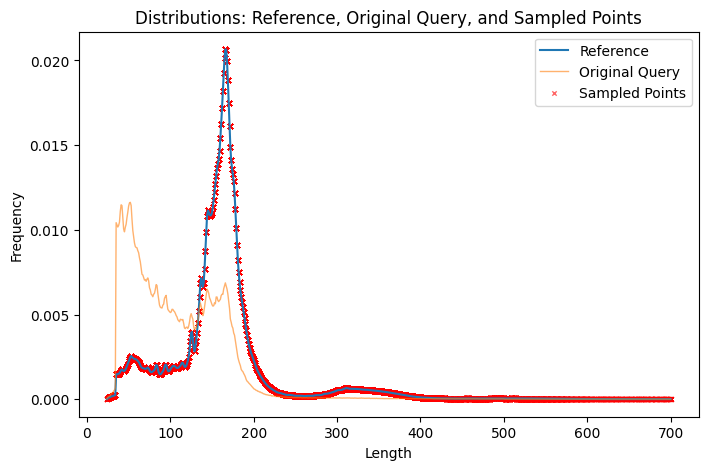

In [63]:

plt.figure(figsize=(8,5))
plt.plot(ref["length"],    ref["freq"],       label="Reference")
plt.plot(query_dist["length"], query_dist["q_freq"],label="Original Query", alpha=0.6, lw=1) 
# plot for mask also
plt.scatter(df_sub["length"], df_sub["freq"], color="red", s=10, label="Sampled Points", alpha=0.6, lw=1,marker='x')
plt.legend()
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("Distributions: Reference, Original Query, and Sampled Points")
plt.show()
